# 🛠️ EffificentDet dataset making

## automl efficientdet 다운로드 및 설치

In [1]:
# efficientdet 공식 깃헙 clone
!git clone --depth 1 https://github.com/google/automl

In [2]:
# 공식 깃헙의 efficientdet으로 경로 이동
%cd ../EfficientDet/automl/efficientdet

/aiffel/aiffel/EfficientDet/automl/efficientdet


In [ ]:
# requirement 설치
!pip install -r requirements.txt

# aimmo 데이터를 efficientdet의 input 파일 형태로 변환

- aimmo 데이터는 이미지(png)와 label(json)으로 이루어짐.
- efficientdet은 input 데이터를 TFRecord 형식으로 받음.
- 따라서 json을 TFRcord 형식으로 변환

In [5]:
# 필요한 라이브러리 import
import os
import sys
import tensorflow.compat.v1 as tf

# sys.path.append('/content/automl/efficientdet')

import hparams_config
from tf2 import anchors
from model_inspect import ModelInspector

In [7]:
import glob
import pandas as pd
import json
import math

# 객체 이름
CLASSES = ['car', 'truck', 'bus', 'pedestrian']

# json 파일을 Pandas DataFrame으로 변환 한뒤 DataFrame의 to_csv()를 이용하여 csv 파일로 생성하고 DataFrame반환
def get_bboxes_from_json(json_file):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    bboxes = []
    bbox_names = []

    if json_data['annotations'] is not None:
        for anno in json_data['annotations']:
            bbox_name = anno['attribute']
            if bbox_name not in CLASSES:
                continue
        
            jsonbox = anno['points']
            xmin = jsonbox[0][0]
            ymin = jsonbox[0][1]
            xmax = jsonbox[2][0]
            ymax = jsonbox[2][1]
            if xmin == xmax or ymin == ymax:
                continue
            bbox = [xmin, ymin, xmax, ymax]
            bboxes.append(bbox)
            bbox_names.append(bbox_name)
    
    return bbox_names, bboxes

bbox_names, bboxes = get_bboxes_from_json('/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1657072552295_FR-View-CMR-Wide.json')
print('object별 class 명:', bbox_names)
print('object별 bbox 정보 list:', bboxes)

object별 class 명: ['truck', 'truck', 'truck', 'truck', 'truck', 'car', 'bus', 'truck', 'truck', 'bus', 'car', 'car', 'truck', 'car']
object별 bbox 정보 list: [[0.0, 0.5849609375, 0.10052083333333334, 0.833984375], [0.5145833333333333, 0.669921875, 0.5786458333333333, 0.7646484375], [0.019270833333333334, 0.5576171875, 0.2869791666666667, 0.7568359375], [0.6229166666666667, 0.599609375, 0.7104166666666667, 0.8251953125], [0.30364583333333334, 0.583984375, 0.48125, 0.75], [0.7208333333333333, 0.7421875, 0.7484375, 0.787109375], [0.7348958333333333, 0.7197265625, 0.7609375, 0.763671875], [0.765625, 0.724609375, 0.7890625, 0.775390625], [0.5317708333333333, 0.6591796875, 0.5890625, 0.7431640625], [0.2755208333333333, 0.62890625, 0.31875, 0.7216796875], [0.2557291666666667, 0.677734375, 0.30104166666666665, 0.736328125], [0.5833333333333334, 0.7119140625, 0.6088541666666667, 0.7451171875], [0.4859375, 0.6669921875, 0.5177083333333333, 0.7421875], [0.6088541666666667, 0.716796875, 0.6234375, 0.7

In [ ]:
# 모든 json 파일의 list 저장
import os
ANNO_DIR = '/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels'
file_list = os.listdir(ANNO_DIR)
json_files = sorted([file for file in file_list if file.endswith('.json')])
print('json file list:', json_files)
print('json file 개수:', len(json_files))

### 개별 JSON 정보와 이미지를 tf.train.Example로 변경하는 함수 생성. 
* https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

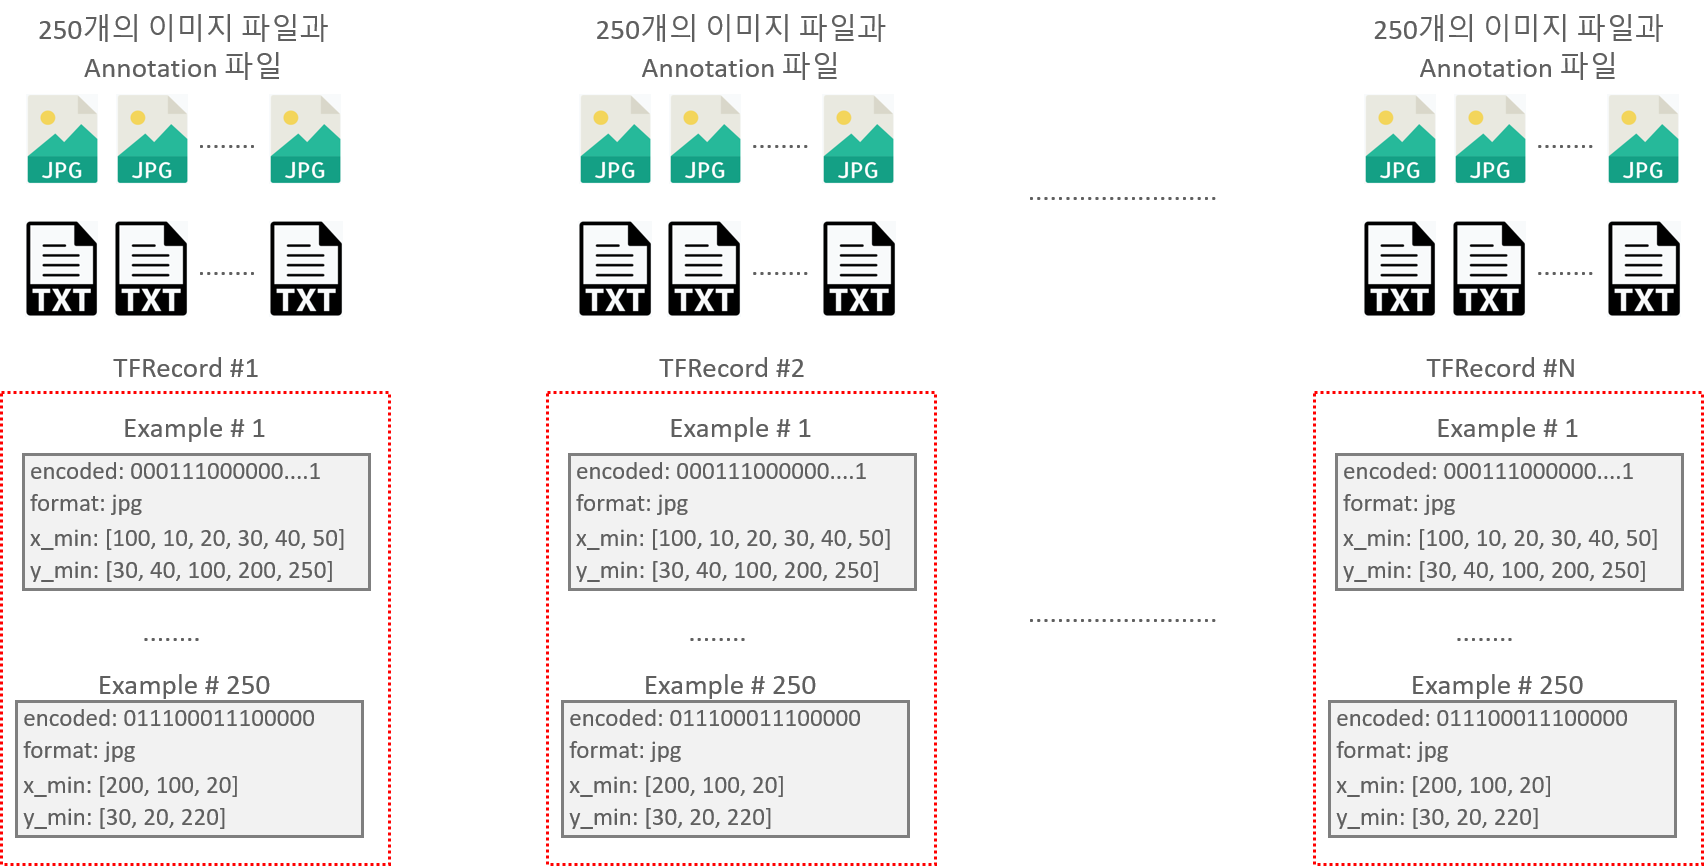

In [9]:
# json 을 파싱해서 image와 object의 메타정보를 dict로 반환하는 함수 
def get_anno_dict_from_json(json_filepath):
    with open(json_filepath, 'r') as f:
        json_data = json.load(f)
    bbox_names = []
    objects = []

    filename = json_data['filename']
    width = 960
    height = 512

    # 파일내에 있는 모든 object Element를 찾음. 
    for anno in json_data['annotations']:
        name = anno['attribute']
        #truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 설정.
        pose = 'Unspecified'
        truncated = 0
        difficult = 0
        occluded = 0


        jsonbox = anno['points']
        xmin = jsonbox[0][0]
        ymin = jsonbox[0][1]
        xmax = jsonbox[2][0]
        ymax = jsonbox[2][1]
        bbox = {
            'xmin': xmin, 
            'ymin': ymin, 
            'xmax': xmax, 
            'ymax': ymax
            }
    
        single_obj = {'name':name, 'pose':pose, 'truncated':truncated, 'difficult':difficult, 'occluded':occluded,
              'bndbox':bbox}
        objects.append(single_obj)

    anno_dict = {
      'folder':'training_data', 'filename':filename, 'width':width, 'height':height,
      'object':objects
    }

    return anno_dict

In [10]:
# 하나의 json에 대해 실험
anno_dict = get_anno_dict_from_json('/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1657072552295_FR-View-CMR-Wide.json')
anno_dict

{'folder': 'training_data',
 'filename': '1657072552295_FR-View-CMR-Wide.png',
 'width': 960,
 'height': 512,
 'object': [{'name': 'truck',
   'pose': 'Unspecified',
   'truncated': 0,
   'difficult': 0,
   'occluded': 0,
   'bndbox': {'xmin': 0.0,
    'ymin': 0.5849609375,
    'xmax': 0.10052083333333334,
    'ymax': 0.833984375}},
  {'name': 'truck',
   'pose': 'Unspecified',
   'truncated': 0,
   'difficult': 0,
   'occluded': 0,
   'bndbox': {'xmin': 0.5145833333333333,
    'ymin': 0.669921875,
    'xmax': 0.5786458333333333,
    'ymax': 0.7646484375}},
  {'name': 'truck',
   'pose': 'Unspecified',
   'truncated': 0,
   'difficult': 0,
   'occluded': 0,
   'bndbox': {'xmin': 0.019270833333333334,
    'ymin': 0.5576171875,
    'xmax': 0.2869791666666667,
    'ymax': 0.7568359375}},
  {'name': 'truck',
   'pose': 'Unspecified',
   'truncated': 0,
   'difficult': 0,
   'occluded': 0,
   'bndbox': {'xmin': 0.6229166666666667,
    'ymin': 0.599609375,
    'xmax': 0.7104166666666667,
   

In [11]:
# image와 object의 고유 id 부여. 
class Unique_Id(object):
  
  def __init__(self):
    self.image_id = 0
    self.ann_id = 0

  def get_image_id(self):
    self.image_id += 1
    return self.image_id

  def get_ann_id(self):
    self.ann_id += 1
    return self.ann_id


In [12]:
# https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

import hashlib
import io
import json
import os
import PIL.Image
import tensorflow as tf
from dataset import tfrecord_util

# 1개의 image 파일 PATH와 1개의 annotation json 정보를 가지는 data dic를 이용하여 tf.train.Example를 생성. 
def dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=True):
    ''' 
    data는  1개의 json 파일을 dictionary로 변환 anno_dict,
    image는 1개의 json에 매핑되는 image 파일의 절대 경로
    unique_id는 고유한 image와 object id를 만들기 위한 Unique_Id객체
    ''' 
    
    #PNG image를 binary 그대로 읽음. 
    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_png = fid.read()
    
    # image가 png 타입인지 확인. 
    encoded_png_io = io.BytesIO(encoded_png)
    image = PIL.Image.open(encoded_png_io)
    if image.format != 'PNG':
        raise ValueError('Image format not PNG')
    
    # image의 고유 key값 생성. 
    key = hashlib.sha256(encoded_png).hexdigest()
    
    #고유한 image id를 생성. 
    image_id = unique_id.get_image_id()
    # image의 width와 height 가져옴. 
    width = data['width']
    height = data['height']
    
    xmins, ymins, xmaxes, ymaxes = [], [], [], []
    areas, classes, classes_texts = [], [], []
    truncated, poses, difficult_obj = [], [], []
    # 만일 annotation에 1개 이상의 object가 있다면, 
    if 'object' in data:
        # data(anno_dict)의 'object' key값으로 개별 object 별 annotation 정보를 dict로 가지는 list로 구성. 이 list를 iteration 수행. 
        for obj in data['object']:
            difficult = bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            # object 명이 ['car', 'truck', 'bus', 'pedestrian']가 아니면 제외. 
            if obj['name'] not in label_map_dict:
                continue
                
            difficult_obj.append(int(difficult))
            # 개별 좌표 값을 이미지의 크기로 정규화하고 list로 저장. 
            xmins.append(float(obj['bndbox']['xmin']))
            ymins.append(float(obj['bndbox']['ymin']))
            xmaxes.append(float(obj['bndbox']['xmax']))
            ymaxes.append(float(obj['bndbox']['ymax']))
            areas.append((xmaxes[-1] - xmins[-1]) * (ymaxes[-1] - ymins[-1]))
            # class명과 class_id를 list로 저장. 
            classes_texts.append(obj['name'].encode('utf8'))
            classes.append(label_map_dict[obj['name']])
            # truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 저장. 
            truncated.append(int(obj['truncated']))
            poses.append(obj['pose'].encode('utf8'))
            difficult_obj.append(obj['difficult'])

    example_dict = {'height':height, 'width':width, 'filename':data['filename'].encode('utf8'),
                  'source_id': str(image_id).encode('utf8'), 'key_sha256': key.encode('utf8'),
                  'encoded': encoded_png, 'format':'png'.encode('utf8'),
                  'xmin':xmins, 'xmax':xmaxes, 'ymin':ymins, 'ymax':ymaxes,
                  'area':areas, 'class_text':classes_texts, 'class_label':classes,
                  'difficult':difficult_obj, 'truncated':truncated, 'poses':poses}
    if debug:
        print('example_dict:', example_dict) 

    example = make_tfrecord_example(example_dict)

    return example

In [13]:
import tensorflow as tf
from dataset import tfrecord_util

# 인자로 들어온 dict에 따라 tf.train.Example을 생성. 
def make_tfrecord_example(example_dict):
  example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': tfrecord_util.int64_feature(example_dict['height']),
                'image/width': tfrecord_util.int64_feature(example_dict['width']),
                'image/filename': tfrecord_util.bytes_feature(example_dict['filename']),
                'image/source_id': tfrecord_util.bytes_feature(example_dict['source_id']),
                'image/key/sha256': tfrecord_util.bytes_feature(example_dict['key_sha256']),
                'image/encoded': tfrecord_util.bytes_feature(example_dict['encoded']),
                'image/format': tfrecord_util.bytes_feature('png'.encode('utf8')),
                'image/object/bbox/xmin': tfrecord_util.float_list_feature(example_dict['xmin']),
                'image/object/bbox/xmax': tfrecord_util.float_list_feature(example_dict['xmax']),
                'image/object/bbox/ymin': tfrecord_util.float_list_feature(example_dict['ymin']),
                'image/object/bbox/ymax': tfrecord_util.float_list_feature(example_dict['ymax']),
                'image/object/area': tfrecord_util.float_list_feature(example_dict['area']),
                'image/object/class/text': tfrecord_util.bytes_list_feature(example_dict['class_text']),
                'image/object/class/label': tfrecord_util.int64_list_feature(example_dict['class_label']),
                'image/object/difficult': tfrecord_util.int64_list_feature(example_dict['difficult']),
                'image/object/truncated': tfrecord_util.int64_list_feature(example_dict['truncated']),
                'image/object/view': tfrecord_util.bytes_list_feature(example_dict['poses']),
            }))
  
  return example


In [ ]:
label_map_dict = {
    'car' : 0, 
    'truck' : 1, 
    'bus' : 2, 
    'Pedestrian' : 3
}

# 테스트 용도로 한개의 Example 생성해 보기 
unique_id = Unique_Id()
data = get_anno_dict_from_json('/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1657072552295_FR-View-CMR-Wide.json')
print('## json 파일을 data dic로 변경 결과:', data)
image_path = '/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1657072552295_FR-View-CMR-Wide.png'

example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None)

In [ ]:
# 예시 출력
example

### 학습과 검증용 TFRecord 파일들을 생성. 
* 학습과 검증용 DataFrame으로 학습, 검증 데이터세트 분류
* 개별 Example을 생성하는 dict_to_tf_example()을 이용하여 모든 데이터 세트를 TFRecord로 생성. 

In [ ]:
file_id_list = sorted([json_file[:json_file.rfind('.json')] for json_file in os.listdir('/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels') \
                if '.json' in json_file])
print(file_id_list)
len(file_id_list)

In [17]:
import pandas as pd

pd.set_option('display.max_colwidth', 300)
data_df = pd.DataFrame({'file_id': file_id_list})
data_df['image_path'] = '/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/' + data_df['file_id'] + '.png'
data_df['json_path'] = '/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/' + data_df['file_id'] + '.json'

print(data_df.shape)
data_df.head()

(10000, 3)


,file_id,image_path,json_path
0,1654739004396_FR-View-CMR-Wide,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1654739004396_FR-View-CMR-Wide.png,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1654739004396_FR-View-CMR-Wide.json
1,1654739005761_FR-View-CMR-Wide,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1654739005761_FR-View-CMR-Wide.png,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1654739005761_FR-View-CMR-Wide.json
2,1654739007265_FR-View-CMR-Wide,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1654739007265_FR-View-CMR-Wide.png,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1654739007265_FR-View-CMR-Wide.json
3,1654739009784_FR-View-CMR-Wide,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1654739009784_FR-View-CMR-Wide.png,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1654739009784_FR-View-CMR-Wide.json
4,1654739012828_FR-View-CMR-Wide,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/images/1654739012828_FR-View-CMR-Wide.png,/aiffel/aiffel/AIFFELTHON/real_dataset/final_dataset/labels/1654739012828_FR-View-CMR-Wide.json


In [18]:
from sklearn.model_selection import train_test_split

# 전체 데이터의 20%를 검증용으로 할당. 
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=2022)
print(train_df.shape, val_df.shape)

(8000, 3) (2000, 3)


In [19]:
# 모든 image/json 파일들을 TFRecord로 생성. 
def make_tfrecords(meta_df, output_dir, output_prefix, num_shards):
    '''
    meta_df: train/val DataFrame에서 입력 xml과 image의 경로를 가져옴. 
    output_dir: 출력 TFRecord가 저장될 directory
    output_prefix: 출력 TFRecord 파일의 prefix명. 
    num_shards: 만들어질 TFRecord 파일의 수
    '''
    json_list = meta_df['json_path'].to_list()
    image_list = meta_df['image_path'].to_list()

    unique_id = Unique_Id()
    # num_shards 만큼의 TFRecordWriter객체 생성. 
    writers = [
        tf.io.TFRecordWriter(output_dir + output_prefix +'-%05d-of-%05d.tfrecord' %
                            (i, num_shards))
        for i in range(num_shards)
        ]
    #json 개수만큼 iteration을 돌려서 Example을 만들고 개별 Example을 특정 shard에 해당하는 TFRecord에 append
    for idx, json_path in enumerate(json_list):
        if idx % 100 == 0:
            print('On image ', idx, 'of ', len(json_list))
    
        data = get_anno_dict_from_json(json_path)
        image_path = image_list[idx]
        # 개별 Example 생성. 
        tf_example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, 
                                    ignore_difficult_instances=False, ann_json_dict=None, debug=False)
        # num_shard만큼 만들어진 TFRecord에 Example을 iteration을 수행하면서 해당하는 TFRecord로 append 
        writers[idx % num_shards].write(tf_example.SerializeToString())
  
    # num_shards 만큼 만들어진 TFRecordWriter 객체 close
    for writer in writers:
        writer.close()

In [20]:
!mkdir -p /aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/train
!mkdir -p /aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/val

In [21]:
print('#### train용 tfrecords 생성 시작 ####')
make_tfrecords(train_df, '/aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/train/', 'train', num_shards=8000)

print('#### val용 tfrecords 생성 시작 ####')
make_tfrecords(val_df, '/aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/val/', 'val', num_shards=2000)

#### train용 tfrecords 생성 시작 ####
On image  0 of  8000
On image  100 of  8000
On image  200 of  8000
On image  300 of  8000
On image  400 of  8000
On image  500 of  8000
On image  600 of  8000
On image  700 of  8000
On image  800 of  8000
On image  900 of  8000
On image  1000 of  8000
On image  1100 of  8000
On image  1200 of  8000
On image  1300 of  8000
On image  1400 of  8000
On image  1500 of  8000
On image  1600 of  8000
On image  1700 of  8000
On image  1800 of  8000
On image  1900 of  8000
On image  2000 of  8000
On image  2100 of  8000
On image  2200 of  8000
On image  2300 of  8000
On image  2400 of  8000
On image  2500 of  8000
On image  2600 of  8000
On image  2700 of  8000
On image  2800 of  8000
On image  2900 of  8000
On image  3000 of  8000
On image  3100 of  8000
On image  3200 of  8000
On image  3300 of  8000
On image  3400 of  8000
On image  3500 of  8000
On image  3600 of  8000
On image  3700 of  8000
On image  3800 of  8000
On image  3900 of  8000
On image  4000 of  

In [22]:
!ls -lia /aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/train
!ls -lia /aiffel/aiffel/AIFFELTHON/real_dataset/tfrecord/val

total 5892776
4063238 drwxr-xr-x 2 root root  458752 Dec  2 02:44 .
4063236 drwxr-xr-x 4 root root    4096 Dec  2 02:44 ..
4063242 -rw-r--r-- 1 root root  790170 Dec  2 02:50 train-00000-of-08000.tfrecord
4063244 -rw-r--r-- 1 root root  663927 Dec  2 02:50 train-00001-of-08000.tfrecord
4063246 -rw-r--r-- 1 root root  551459 Dec  2 02:50 train-00002-of-08000.tfrecord
4063248 -rw-r--r-- 1 root root 1090759 Dec  2 02:50 train-00003-of-08000.tfrecord
4063252 -rw-r--r-- 1 root root  860859 Dec  2 02:50 train-00004-of-08000.tfrecord
4063254 -rw-r--r-- 1 root root  639939 Dec  2 02:50 train-00005-of-08000.tfrecord
4063256 -rw-r--r-- 1 root root  869488 Dec  2 02:50 train-00006-of-08000.tfrecord
4063258 -rw-r--r-- 1 root root  789311 Dec  2 02:50 train-00007-of-08000.tfrecord
4063260 -rw-r--r-- 1 root root  813000 Dec  2 02:50 train-00008-of-08000.tfrecord
4063262 -rw-r--r-- 1 root root  759954 Dec  2 02:50 train-00009-of-08000.tfrecord
4063264 -rw-r--r-- 1 root root  932080 Dec  2 02:50 train

4064890 -rw-r--r-- 1 root root  802573 Dec  2 02:50 train-01595-of-08000.tfrecord
4064891 -rw-r--r-- 1 root root  811978 Dec  2 02:50 train-01596-of-08000.tfrecord
4064892 -rw-r--r-- 1 root root  897857 Dec  2 02:50 train-01597-of-08000.tfrecord
4064893 -rw-r--r-- 1 root root  900995 Dec  2 02:50 train-01598-of-08000.tfrecord
4064894 -rw-r--r-- 1 root root  814901 Dec  2 02:50 train-01599-of-08000.tfrecord
4064895 -rw-r--r-- 1 root root  505234 Dec  2 02:50 train-01600-of-08000.tfrecord
4064896 -rw-r--r-- 1 root root  650957 Dec  2 02:50 train-01601-of-08000.tfrecord
4064897 -rw-r--r-- 1 root root  897245 Dec  2 02:50 train-01602-of-08000.tfrecord
4064898 -rw-r--r-- 1 root root  846765 Dec  2 02:50 train-01603-of-08000.tfrecord
4064899 -rw-r--r-- 1 root root  511926 Dec  2 02:50 train-01604-of-08000.tfrecord
4064900 -rw-r--r-- 1 root root  899191 Dec  2 02:50 train-01605-of-08000.tfrecord
4064901 -rw-r--r-- 1 root root  780120 Dec  2 02:50 train-01606-of-08000.tfrecord
4064902 -rw-r--r

4071232 -rw-r--r-- 1 root root  759657 Dec  2 02:50 train-07884-of-08000.tfrecord
4071233 -rw-r--r-- 1 root root  810616 Dec  2 02:50 train-07885-of-08000.tfrecord
4071234 -rw-r--r-- 1 root root  812214 Dec  2 02:50 train-07886-of-08000.tfrecord
4071235 -rw-r--r-- 1 root root  601320 Dec  2 02:50 train-07887-of-08000.tfrecord
4071236 -rw-r--r-- 1 root root  828456 Dec  2 02:50 train-07888-of-08000.tfrecord
4071237 -rw-r--r-- 1 root root  745242 Dec  2 02:50 train-07889-of-08000.tfrecord
4071238 -rw-r--r-- 1 root root  727569 Dec  2 02:50 train-07890-of-08000.tfrecord
4071239 -rw-r--r-- 1 root root  817465 Dec  2 02:50 train-07891-of-08000.tfrecord
4071240 -rw-r--r-- 1 root root  790808 Dec  2 02:50 train-07892-of-08000.tfrecord
4071241 -rw-r--r-- 1 root root  797730 Dec  2 02:50 train-07893-of-08000.tfrecord
4071242 -rw-r--r-- 1 root root  903654 Dec  2 02:50 train-07894-of-08000.tfrecord
4071243 -rw-r--r-- 1 root root  887764 Dec  2 02:50 train-07895-of-08000.tfrecord
4071244 -rw-r--r

total 1478932
4063240 drwxr-xr-x 2 root root  118784 Dec  2 02:50 .
4063236 drwxr-xr-x 4 root root    4096 Dec  2 02:44 ..
4071348 -rw-r--r-- 1 root root  941439 Dec  2 02:52 val-00000-of-02000.tfrecord
4071349 -rw-r--r-- 1 root root  857362 Dec  2 02:52 val-00001-of-02000.tfrecord
4071350 -rw-r--r-- 1 root root  915783 Dec  2 02:52 val-00002-of-02000.tfrecord
4071351 -rw-r--r-- 1 root root  656634 Dec  2 02:52 val-00003-of-02000.tfrecord
4071352 -rw-r--r-- 1 root root  652404 Dec  2 02:52 val-00004-of-02000.tfrecord
4071353 -rw-r--r-- 1 root root  678532 Dec  2 02:52 val-00005-of-02000.tfrecord
4071354 -rw-r--r-- 1 root root  893328 Dec  2 02:52 val-00006-of-02000.tfrecord
4071355 -rw-r--r-- 1 root root  789664 Dec  2 02:52 val-00007-of-02000.tfrecord
4071356 -rw-r--r-- 1 root root  641306 Dec  2 02:52 val-00008-of-02000.tfrecord
4071357 -rw-r--r-- 1 root root  844827 Dec  2 02:52 val-00009-of-02000.tfrecord
4071358 -rw-r--r-- 1 root root  704170 Dec  2 02:52 val-00010-of-02000.tfreco